**This notebook shows how machine learning techniques  can apply in Semi-conductor Industry.**

**Our Objective:** To identify different types of wafer map failure pattern automatically instead of manual work, so that the semi-conductor fabrication can improve on the yield of wafers manufacturing process.

Here, we list all reference:

[1]Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets [paper downloas link](http://ieeexplore.ieee.org/document/6932449/)

[2]Wafer Defect Patterns Recognition Based on OPTICS and Multi-Label Classification [paper download link](http://ieeexplore.ieee.org/document/7867343/)

**Step1:  Define your problem**

* **Input:** WM-811K dataset provided by *[MIR lab]*(http://mirlab.org/dataSet/public/). 

  *(For convenience, I have converted the original (dot)mat file to (dot)pkl file and you may download from this kernel.)*

* **Model:** One-VS-One multi-class SVMs. 

* **Output:** Failure pattern labels.
* https://www.kaggle.com/code/ashishpatel26/wm-811k-wafermap

In [15]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import os
print(os.listdir("D:\AI in EDA\LSWMD(Kaggle)"))
import warnings
warnings.filterwarnings("ignore")

['.ipynb_checkpoints', 'LSWMD.pkl', 'WM-811k Wafermap_yingyi.ipynb', 'wm-811k-wafermap_NOWYSM.ipynb', 'wm-811k-wafermap_yingyi.ipynb']


**Step2: Prepare your data**

* **Data Selection & Preprocessing: ** Consider what data is available, what data is missing and what data can be removed. Also, organize your selected data by formatting, cleaning and sampling from it.

Here is a simple **checklist** provided for you to understand your dataset better:

* Data summary
* Target distribution
* Missing value check
* Others

>** Data summary**

In [16]:
df=pd.read_pickle('D:\AI in EDA\LSWMD(Kaggle)\LSWMD.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


* The dataset comprises **811,457 wafer maps**, along with additional information such as **wafer die size**, **lot name** and **wafer index**. 

* The training / test set were already split by domain experts, but in this kernel we ignore this info and we re-divided the dataset into training set and test set by hold-out mehtod which will be introduced in later section.

>Target distribution

In [17]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [18]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


* The dataset were collected from **47,543 lots** in real-world fab. However, **47,543 lots x 25 wafer/lot =1,157,325 wafer maps ** is larger than **811,457 wafer maps**. 

* Let's see each column. 

**<font size = 5>Column Introduction</font>**
* waferMap
* dieSize
* lotName
* waferIndex
* trianTestLabel
* failureType: Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none.

**1. waferMap**

In [19]:
# waferMap
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
242970,"[[0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 1, 0, 0,...",260.0,lot15109,5.0,[],[],"(18, 19)"
536495,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot33515,16.0,[],[],"(32, 29)"
694403,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",1137.0,lot42797,5.0,[],[],"(38, 38)"
146744,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot9417,18.0,[],[],"(212, 84)"
46949,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6295.0,lot3970,22.0,[],[],"(113, 71)"


* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.

*  **'waferMapDim'** are not in the same size, reshape **'waferMapDim'** before input model


In [20]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [21]:
# waferMap values 0,1,2 stands for background, activate, defect?
def count_waferMap_values(waferMapRow): # ex: df["waferMap"][waferMapRow]  
    list_value_counts = {}
    for i in df["waferMap"][waferMapRow]:
            for j in i:
                if j not in list_value_counts:
                    list_value_counts[j] = 1
                else:
                    list_value_counts[j] +=1
    return list_value_counts
count_waferMap_values(0)

{0: 477, 2: 88, 1: 1595}

**2. dieSize, lotName, waferIndex**
- analyzing the number type columns
- remove waferIndex since it's only index number (in the begining of the next stage)

In [22]:
df2 = df.drop(['waferMap', 'trianTestLabel', 'failureType',"waferMapDim"], axis = 1)
for col in df2:
    print(col, df2[col].unique())
    df2[col].describe()


dieSize [1683. 2460.  533. ...  551.  554.  550.]
lotName ['lot1' 'lot2' 'lot3' ... 'lot47541' 'lot47542' 'lot47543']
waferIndex [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [23]:
df2.describe(include='all') 

,dieSize,lotName,waferIndex
count,811457.000000,811457,811457.000000
unique,NaN,46293,NaN
top,NaN,lot1,NaN
freq,NaN,25,NaN
mean,1840.998585,NaN,12.961207
std,2254.987374,NaN,7.207489
min,3.000000,NaN,1.000000
25%,710.000000,NaN,7.000000
50%,953.000000,NaN,13.000000
75%,1902.000000,NaN,19.000000


In [24]:
for col in df2:
    print(df2[col].value_counts())
    print("-"*40)

710.0     66961
515.0     45725
712.0     42572
1513.0    39322
776.0     29513
          ...  
2322.0        1
2309.0        1
2277.0        1
2273.0        1
586.0         1
Name: dieSize, Length: 1266, dtype: int64
----------------------------------------
lot1        25
lot26113    25
lot26129    25
lot26125    25
lot26124    25
            ..
lot9377      1
lot33363     1
lot33362     1
lot33337     1
lot31847     1
Name: lotName, Length: 46293, dtype: int64
----------------------------------------
6.0     32745
4.0     32714
5.0     32701
7.0     32672
2.0     32663
8.0     32650
11.0    32637
9.0     32636
3.0     32621
12.0    32598
10.0    32586
1.0     32516
13.0    32381
16.0    32362
14.0    32353
17.0    32333
18.0    32333
21.0    32320
22.0    32312
15.0    32301
20.0    32290
19.0    32285
23.0    32202
24.0    32197
25.0    32049
Name: waferIndex, dtype: int64
----------------------------------------


**3. trianTestLabel, failureType**

In [25]:
# One-hit-encoding df['failureNum'] & df['trainTestNum']
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

# count pattern and labels
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]

tol_wafers = df.shape[0]
tol_wafers

print('total', tol_wafers)
print("with label", df_withlabel.shape[0])
print('With Pattern',df_withpattern.shape[0])
print('Without Pattern', df_nonpattern.shape[0])

total 811457
with label 172950
With Pattern 25519
Without Pattern 147431


In [26]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel['failureNum'].value_counts()

8    147431
3      9680
2      5189
0      4294
4      3593
6      1193
5       866
1       555
7       149
Name: failureNum, dtype: int64

- 'Center'(0):4294
- 'Donut'(1):555
- 'Edge-Loc'(2):5189
- 'Edge-Ring'(3):9680
- 'Loc'(4):3593
- 'Random'(5):866
- 'Scratch'(6):1193
- 'Near-full'(7):149
- 'none'(8):147431

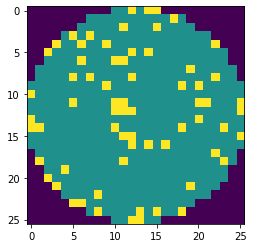

Faulty case : ['none'] 


In [27]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
    
x = sw[1:]
y = np.array(label).reshape((-1,1))

# plot 1st data
plt.imshow(x[2040])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[2040]))

We may also showing the wafer map by failure patterns:

- Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full

In [11]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

* From each failure type, we selected the most typical failure pattern for visualization.

>**Missing value check**

* Do not be afraid to handle so large dataset. When you look into the dataset you may notice quite number of data are useless due to **missing values**.

* Do missing value check is an important part during data preparing process. Since we only interested in wafer with patterns, we may remove those data without failure type labels. 

In [12]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [31]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

* In summary, 172,950 wafers have labels while **78.7% wafers with no label**  based on failureType variable filtering.
* Among labeled wafer,  only **3.1% wafers **(25,519 wafers) have real failure patterns while 147,431 wafers were still labeled none. As a result, we only focus on thoes 25,519 instances which heavily **reduce the calculated amount** for our work. 
* From the second picture shown above, the dataset shows high imbalance distribution.

> **Picture is worth a thousand words** 

* The best way to observe the raw data is to do ** data visualization**.

* We show the **first 100 samples** with pattern labeled from our datasets.

In [ ]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

* We may also showing the wafer map by failure patterns: 
    
   **Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full**

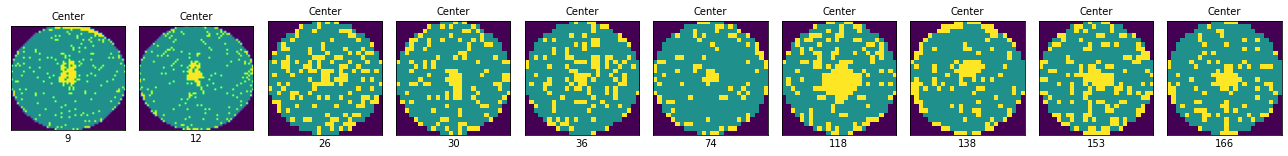

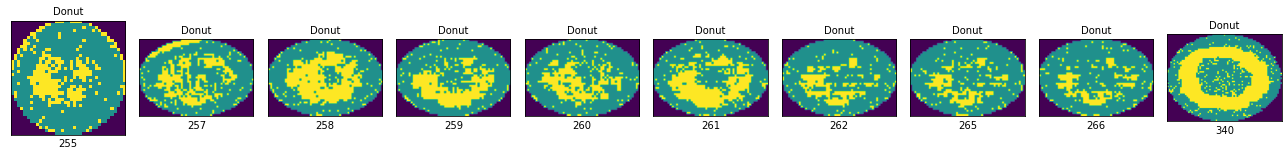

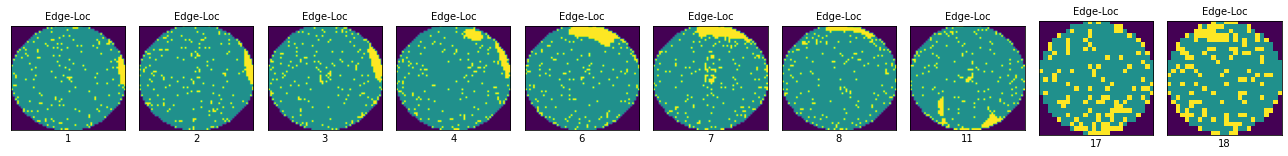

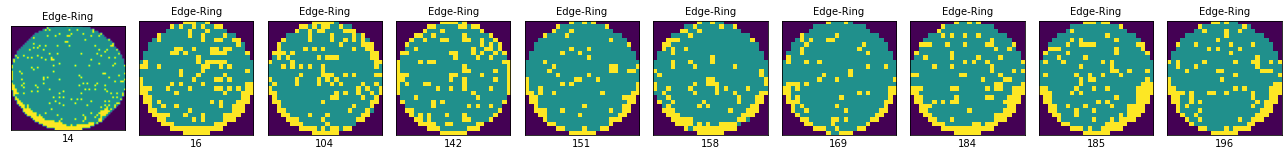

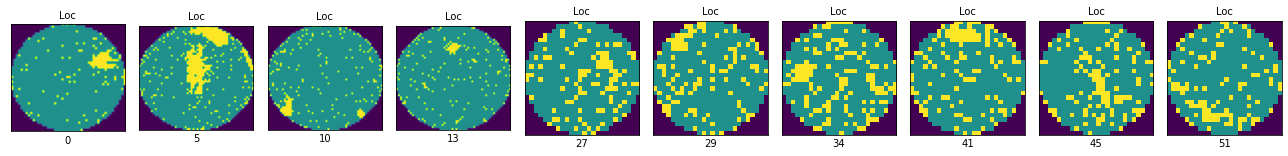

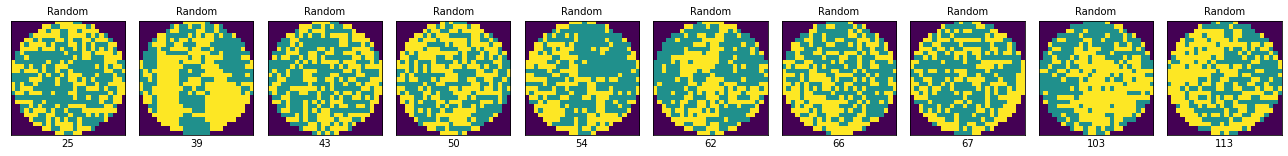

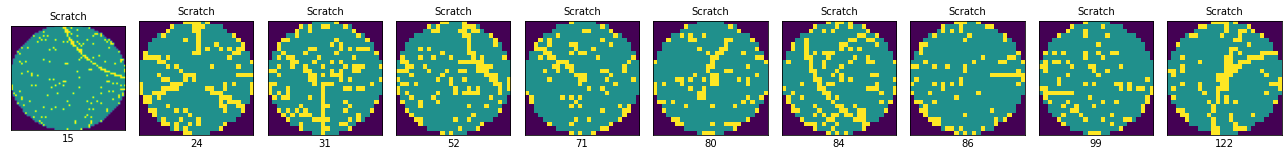

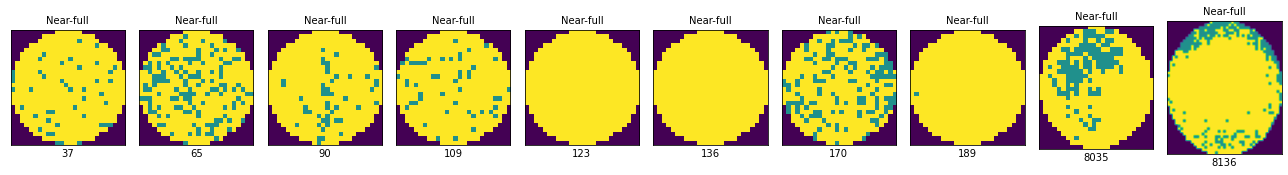

In [28]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withpattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

* From each failure type, we selected the most **typical failure pattern** for visualization.

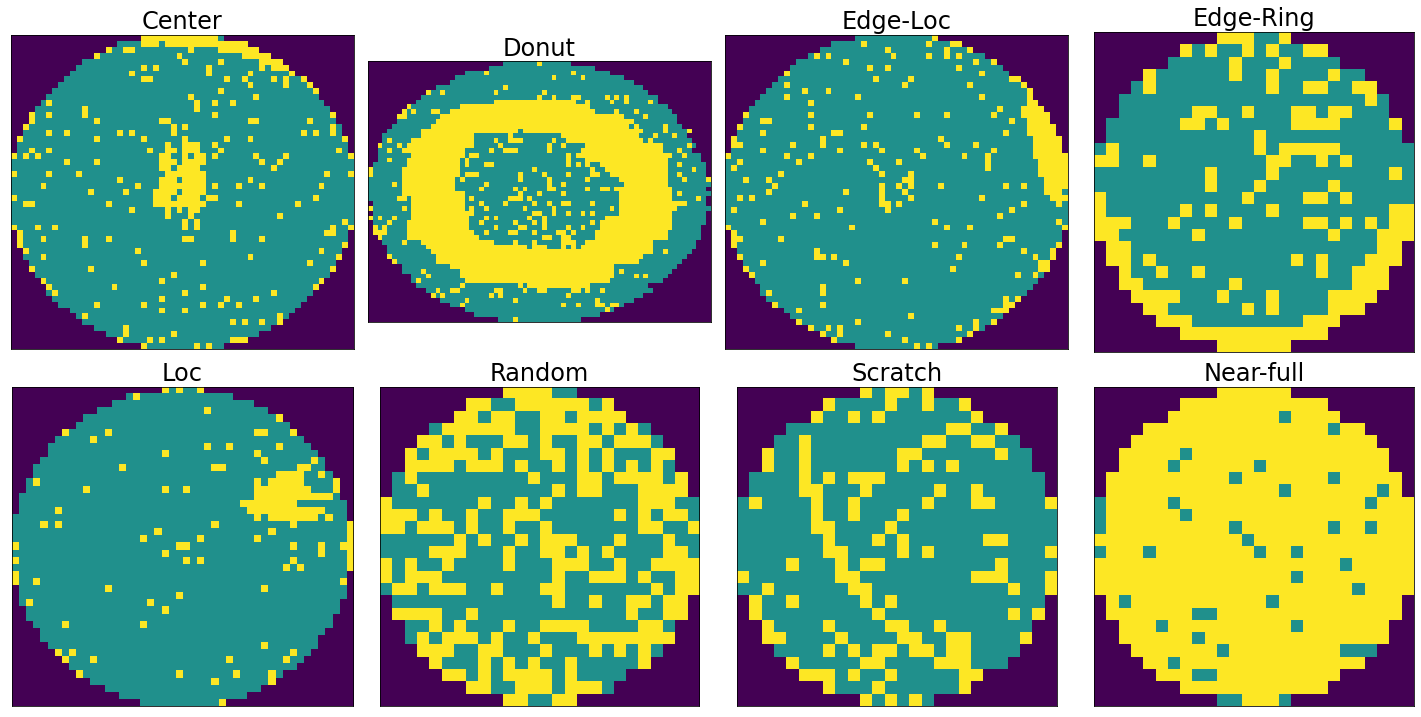

In [29]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

**Step2: Prepare your data** (Cont.)

* **Data Transformation:** Transform preprocessed data ready for machine learning by engineering features using scaling, attribute decomposition and attribute aggregation.


In [30]:
# loading libraries
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

> **Density-based Features (13)**

* Divided wafer map into 13 parts and computed defects density accordingly. The 13 regions includes the inner 9 same regions and the top, bottom, left and right regions. 

* For each failure type, it has different density distribution patterns. For example, the center one of the inner 9 regions  will have high defects density for Center failure type.

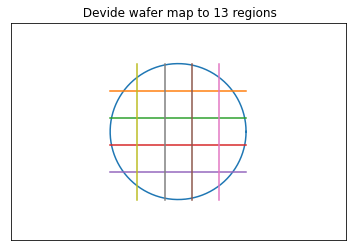

In [32]:
# illustration of 13 regions
an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])
plt.title(" Devide wafer map to 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

In [33]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [34]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

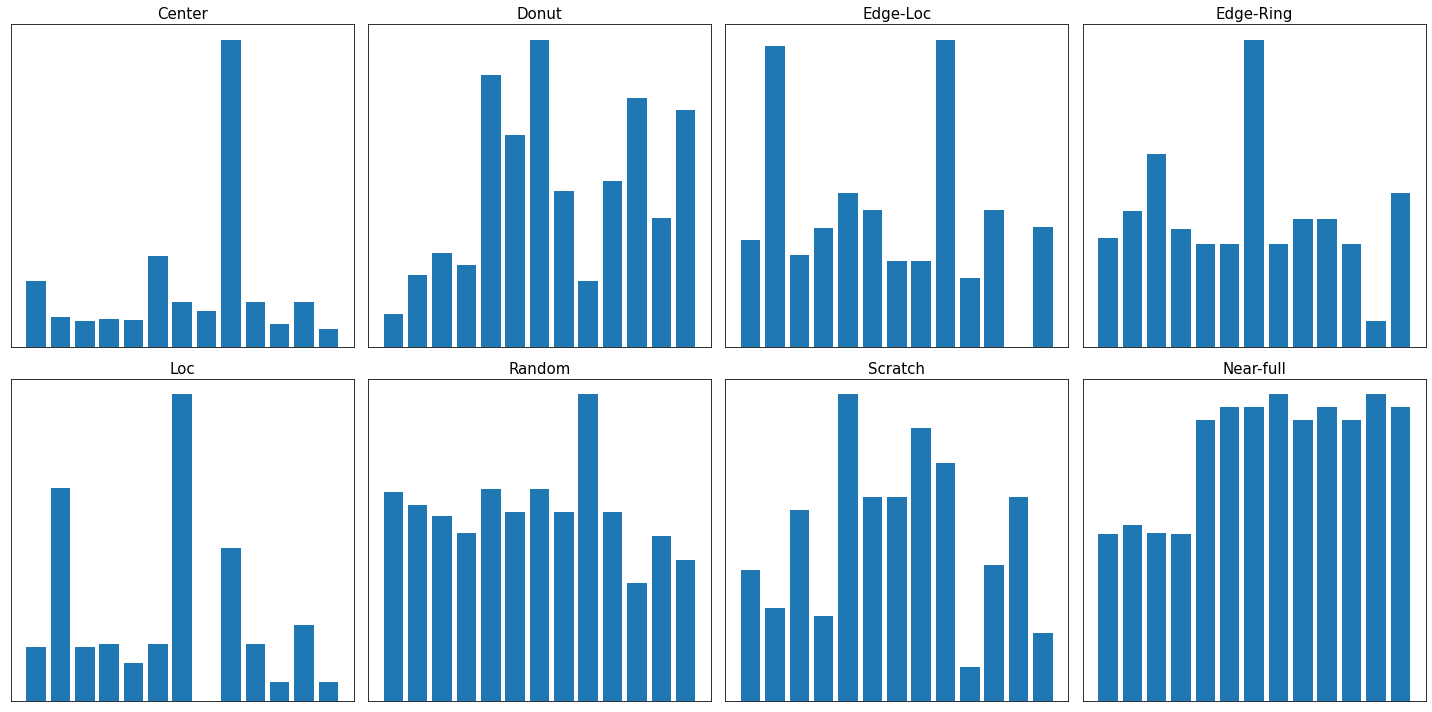

In [35]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

* The picture above shows density based features for 8 typical failure types. 

* It turns out that extracting density based feature is resonable and making the dataset more classifiable.

> **Randon-based Features (40)**

* Randon-based features are based on the radon transform, which can generate a 2d representation of the wafer map according to a series of projections.

* For Radon transform, please refer to scikit-image link about [Radon transform](http://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html).


In [ ]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

* The picture above shows radon tranform results for 8 typical failure types. 

* However, even we obtained radon transform values, we can not regard as features because the wafer vary in size. so in the next step, we using cubic interpolation to obtain fixed dimension feature values for row mean and row standard deviation from radon transform, for each one the dimension is fixed to 20.

* In total, we extracted 40 dimensions for radon-based features.

* For Cubic interpolation, please refer to scikit-image link about [Cubic interpolation](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html).

In [ ]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [ ]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)

> **Radon-based feature (interpolate from row mean) **

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,1])
plt.tight_layout()
plt.show() 

>** Radon-based feature (interpolate from row standard deviation)**

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_std[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,0.3])
plt.tight_layout()
plt.show() 

> **Geometry-based Features (6)**

* Most **salient region identifying** can be regarded as noise filtering. In this work, we use region-labeling algorithm and choose the max area region as the most salient one.

* Based on the salient region, we try to extract geometry features like area, perimeter, length of major axes,  length of minor axes, solidity and eccentricity.


In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)
    img_labels = img_labels-1
    if img_labels.max()==0:
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis = None)
        no_region = info_region[0]
    
    zero_img[np.where(img_labels==no_region)] = 2 
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 

In [ ]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [ ]:
df_withpattern_copy.fea_geom[340] #donut

> **Combine all features together**

* density-based features: 13

* radon-based features: 40

* geom-based features: 6

* in total: 13+40+6=59   

In [ ]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [ ]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

**Step3: Choose algorithms**

* If you have no idea which algorithm to choose, you may have a look on this Microsoft Azure Machine Learning Algorithm Cheat Sheet. Here is the link:[Machine Learning Algorithm Cheat Sheet](https://unsupervisedmethods.com/cheat-sheet-of-machine-learning-and-python-and-math-cheat-sheets-a4afe4e791b6)

> No Best Machine Learning Algorithm

You cannot know a priori which algorithm will be best suited for your problem.

Here are some tips:

* You can apply your favorite algorithm.
* You can apply the algorithm recommended in a book or paper.
* You can apply the algorithm that is winning the most Kaggle competitions right now.
* You can apply the algorithm that works best with your test rig, infrastructure, database, or whatever.

For our multi class classification problem, we choose the most popular SVMs at the moment. 

> This module implements multiclass and multilabel learning algorithms: 

Refer to [scikits learning](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/multiclass.html)

* **one-vs-the-rest :** one-vs-the-rest strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. 

* **one-vs-one:** one-vs-one classifier constructs one classifier per pair of classes.

* error correcting output codes

We choose **One-VS-One multi-class SVMs** as our model based on literature review for this dataset.


In [37]:
import theano
from theano import tensor as T
from sklearn.cross_validation import train_test_split
from keras.utils import np_utils

X = fea_all
y = label

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42


ModuleNotFoundError: No module named 'theano'

In [36]:
# ---multicalss classification ---# 
# One-Vs-One
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
clf2 = OneVsOneClassifier(LinearSVC(random_state = RANDOM_STATE)).fit(X_train, y_train)
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)
train_acc2 = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc2 = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]
print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train[:100]: ", y_train[:100])

NameError: name 'RANDOM_STATE' is not defined

* The overall training accuracy is: **80.36%**

* The overall testing accuracy is: **79.04%**

**Step4: Present results**

* pattern recognition confusion matrix

In [34]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

NameError: name 'y_test' is not defined

> **Step5: Improve results**

In summary, the process of improving results involves:

* Algorithm Tuning: where discovering the best model is treated like a search problem through model parameter space.

* Ensemble Methods: where the predictions made by multiple models are combined.

* Extreme Feature Engineering: where the attribute decomposition and aggregation seen in data preparation is pushed to the limits.

You can discover more about in this blog: [Jason Brownlee's blog](https://machinelearningmastery.com/process-for-working-through-machine-learning-problems/)
